# Q3 AirPassengers

Will focus on air travel and provides information on monthly passenger volumes and also, we will analyse seasonality, and understand the overall trends in air passenger traffic. To forecast future passenger volumes, we will apply an appropriate time series model. This will allow us to make accurate predictions and assist in planning airline operations.

We will apply two appropriate Time Series models to the data we have: Holt-Winters and TBATS. Both models are used for forecasting the given data and work with trends and seasonality. 

In [2]:
import warnings  
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import missingno as msno
from ydata_profiling import ProfileReport

from tbats import TBATS
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

sns.set(color_codes=True)
sns.set_style('darkgrid')
%matplotlib inline 

In [3]:
df = pd.read_csv('Q3AirPassengers.csv', index_col = 'Month', parse_dates = True)
df

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [5]:
# pip install ydata-profiling

In [6]:
# !pip install missingno

In [7]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Data Wrangling

In [3]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
df.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


There are no missing values 



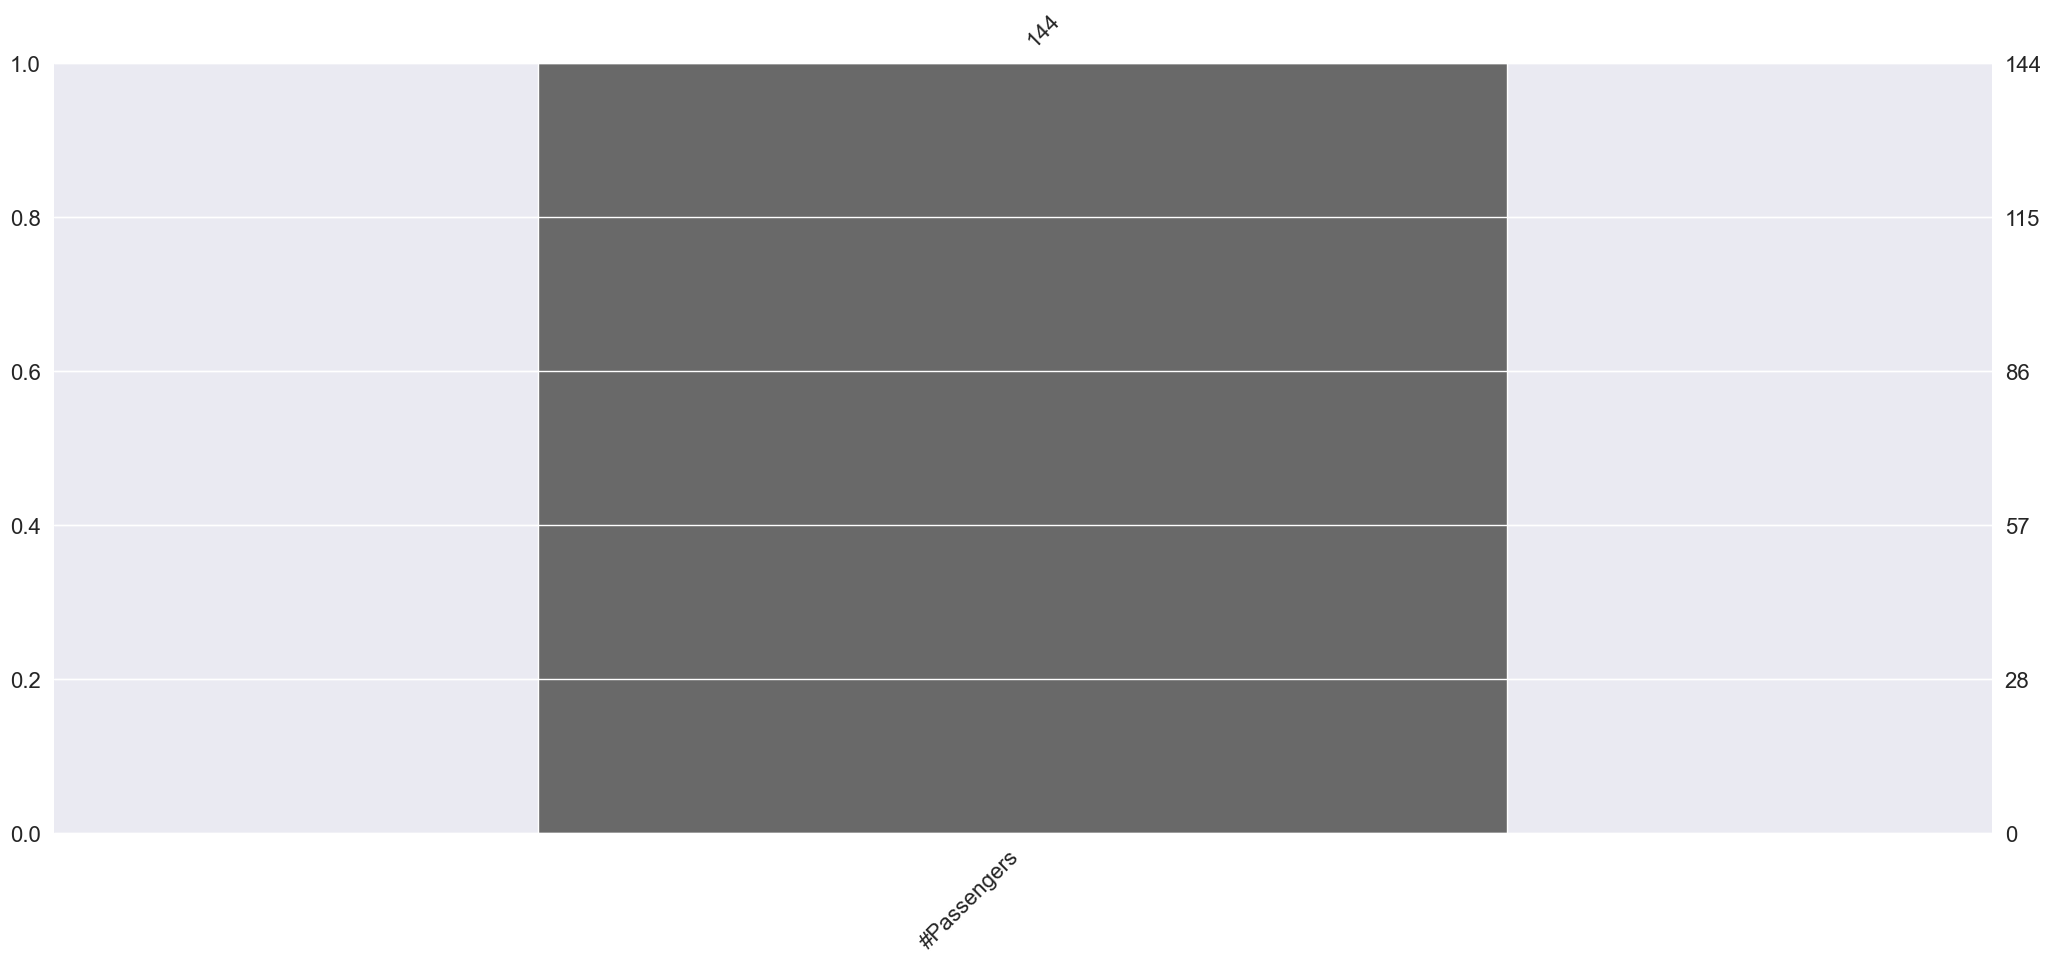

In [6]:
ax = msno.bar(df)

print('There are no missing values','\n')

In [7]:
# Rename the dependent variable

df = df.rename(columns = {'#Passengers' : 'y'})
df.head(5)

,y
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [8]:
# Exploring the dates

df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [9]:
# Modify the index to daily frequency

df = df.asfreq("D") # Change the frecuency to daily
df.index

DatetimeIndex(['1949-01-01', '1949-01-02', '1949-01-03', '1949-01-04',
               '1949-01-05', '1949-01-06', '1949-01-07', '1949-01-08',
               '1949-01-09', '1949-01-10',
               ...
               '1960-11-22', '1960-11-23', '1960-11-24', '1960-11-25',
               '1960-11-26', '1960-11-27', '1960-11-28', '1960-11-29',
               '1960-11-30', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=4353, freq='D')

In [10]:
# Resample the DataFrame to monthly frequency

df_monthly = df.resample("M").sum()
df_monthly.head()

,y
Month,
1949-01-31,112.00
1949-02-28,118.00
1949-03-31,132.00
1949-04-30,129.00
1949-05-31,121.00


## Visualization 

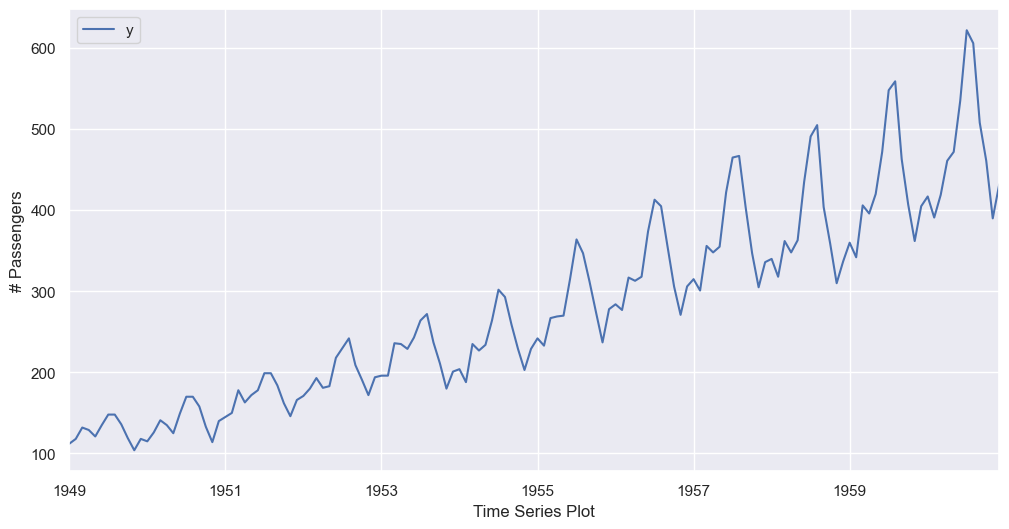

In [11]:
df_monthly.plot(figsize=(12, 6), legend=True)
plt.ylabel('# Passengers')
plt.xlabel('Time Series Plot');

# Holt-Winters Model

In [12]:
# Training and Test set split

test_months = 10
training_set = df_monthly.iloc[:-test_months, :]  # All rows except the last 10 months
test_set = df_monthly.iloc[-test_months:, :]  # The last 10 months to forecast

#### All rows except the last 10 observations

In [13]:
training_set.head()

,y
Month,
1949-01-31,112.00
1949-02-28,118.00
1949-03-31,132.00
1949-04-30,129.00
1949-05-31,121.00


In [14]:
training_set.tail()

,y
Month,
1959-10-31,407.00
1959-11-30,362.00
1959-12-31,405.00
1960-01-31,417.00
1960-02-29,391.00


#### The last 10 months to forecast

In [15]:
test_set.tail(10)

,y
Month,
1960-03-31,419.00
1960-04-30,461.00
1960-05-31,472.00
1960-06-30,535.00
1960-07-31,622.00
1960-08-31,606.00
1960-09-30,508.00
1960-10-31,461.00
1960-11-30,390.00


In [16]:
# We create the model

holtw_model = ExponentialSmoothing(endog = training_set.y,
                             trend = 'mul',
                             seasonal = 'mul',
                             seasonal_periods = 12).fit() # monthly data, 12 months in a year

# endog is the dependent variable
# trend: we need to indicate if it is multiplicative or additive
# seasonal: this is the seasonality. We use multiplicative 
# seasonal periods: In this case the general interval will happen every 12 months (monthly seasonality period)

In [17]:
# Predictions
# we want to predict the size of the test set

predictions_hw = holtw_model.forecast(steps = len(test_set)).rename("HW") # forecast the last 10 months
predictions_hw.head(10)

1960-03-31   465.39
1960-04-30   453.28
1960-05-31   478.36
1960-06-30   549.68
1960-07-31   636.61
1960-08-31   646.77
1960-09-30   530.93
1960-10-31   465.43
1960-11-30   409.50
1960-12-31   452.63
Freq: M, Name: HW, dtype: float64

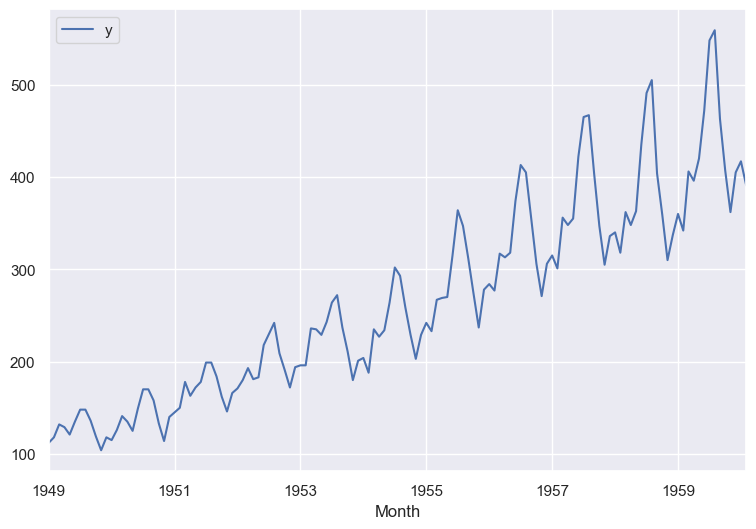

In [18]:
# Visualisation of our model

training_set['y'].plot(figsize = (9,6), legend = True);

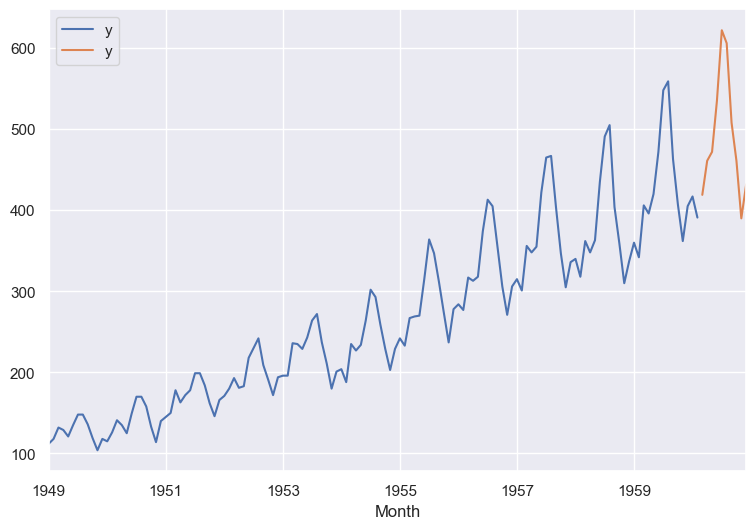

In [19]:
# Visualisation of our model test set Vs training set

# Yellow test set 
# Blue training set

training_set['y'].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True);

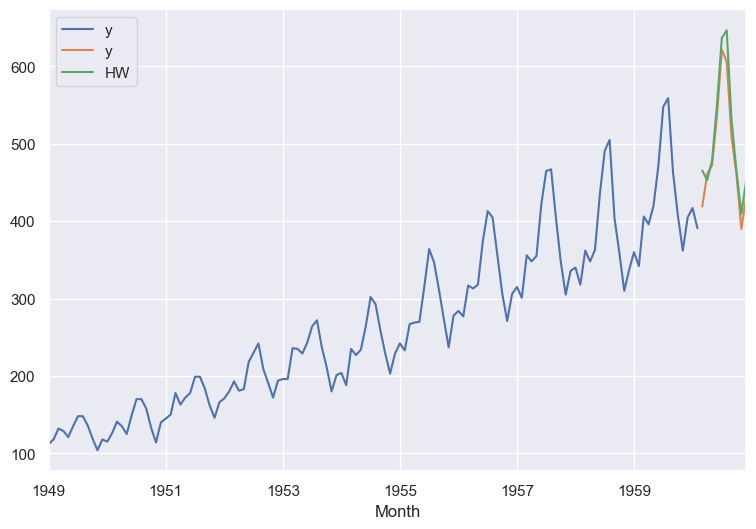

In [20]:
# Visualisation of our model 

# Yellow - test set 
# Blue - training set
# Green - prediction

training_set['y'].plot(figsize = (9,6), legend = True)
test_set['y'].plot(legend = True)
predictions_hw.plot(legend = True);

## Model assessment

In [21]:
# We analyse MAE and RMSE - IMPORTANT

# we round the number, and I will include 0 because I don't want decimals in the result for the visualisation
print('MAE:',round(mean_absolute_error(test_set['y'], predictions_hw),0)) # TEST SET Vs TRAINING SET

# we round the number, and I will include 0 because I don't want decimals in the result for the visualisation
print('RMSE:',round(np.sqrt(mean_squared_error(test_set['y'], predictions_hw)), 0))

MAE: 20.0
RMSE: 24.0


### MAPE function

In [22]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_hw)

4.1159481531319635

### Accuracy Holt-Winters Model

In [23]:
perc = 100
mape = 4.1159481531319635
result = perc - mape

print('Accuracy Holt-Winters Model: {:.4f}%'.format(result))

Accuracy Holt-Winters Model: 95.8841%


# TBATS Model

In [44]:
# TBATS model

model = TBATS(use_trend = True, seasonal_periods = [12]) # seasonal period of 12 months (1 year) for monthly data
model = model.fit(training_set['y'])

In [45]:
# We perform predictions

predictions_tbats = model.forecast(steps = len(test_set))
predictions_tbats

array([461.86648387, 444.43681051, 448.13682999, 508.21235075,
       568.62927831, 566.23583748, 497.45816428, 433.02019178,
       380.34028333, 427.84558364])

We have an array of numbers, so we need to give it the structure of a dataframe

In [34]:
# We perform predictions and use Pandas to give structure to the data

predictions_tbats = pd.Series(model.forecast(steps = len(test_set)))
predictions_tbats.head()

0   461.87
1   444.44
2   448.14
3   508.21
4   568.63
dtype: float64

The outcome is still incomplete. We do not have a name of the frame and we do not have an index

In [35]:
# We perform predictions, use Pandas to give structure to the data, rename the prediction and set the index

predictions_tbats = pd.Series(model.forecast(steps = len(test_set))).rename("TBATS")
predictions_tbats.index = test_set.index
predictions_tbats.head()

Month
1960-03-31   461.87
1960-04-30   444.44
1960-05-31   448.14
1960-06-30   508.21
1960-07-31   568.63
Freq: M, Name: TBATS, dtype: float64

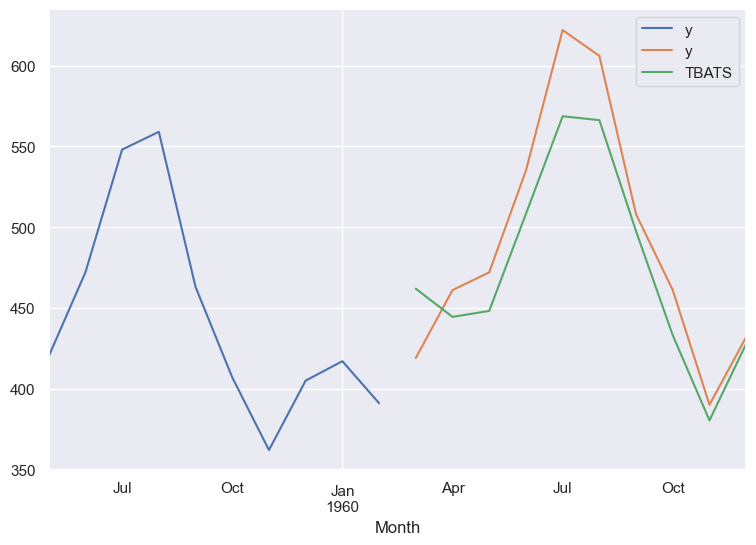

In [37]:
# Visualisation of our model

training_set['y'][-10:].plot(figsize = (9,6), legend = True) # The last 10 observations
test_set['y'].plot(legend = True)
predictions_tbats.plot(legend = True);

# blue line Traininig
# yellow line test
# green line prediction

## Model assessment

In [40]:
# We analyse MAE and RMSE - IMPORTANT

# we round the number, and I will include 0 because I don't want decimals in the result for the visualisation
print('MAE:',round(mean_absolute_error(test_set['y'], predictions_tbats),0)) # TEST SET Vs TRAINING SET

# we round the number, and I will include 0 because I don't want decimals in the result for the visualisation
print('RSME:',round(np.sqrt(mean_squared_error(test_set['y'], predictions_tbats)), 0))

MAE: 26.0
RMSE: 30.0


### MAPE function

In [41]:
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_tbats)

5.0611643741909225

### Accuracy TBATS Model

In [43]:
perc = 100
mape = 5.0611643741909225
result = perc - mape

print('Accuracy TBATS Model: {:.4f}%'.format(result))

Accuracy TBATS Model: 94.9388%


## Assesing the models

In [4]:
data = {
    'Time Series Models': ['Holt-Winters','TBATS'],
    'MAE': [20,26],
    'RSME': [24,30]}

profit_comparison = pd.DataFrame(data)
profit_comparison.set_index('Time Series Models', inplace=True)
profit_comparison

,MAE,RSME
Time Series Models,,
Holt-Winters,20,24
TBATS,26,30


## Collect Models Data

In [47]:
models = ['Holt-Winters', 'TBATS']

scores = [95.8841, 94.9388] 

## Time Series Models Comparison

In [48]:
models_comparison = pd.DataFrame()

models_comparison['Test Score'] = scores
models_comparison.index = models
models_comparison

,Test Score
Holt-Winters,95.88
TBATS,94.94


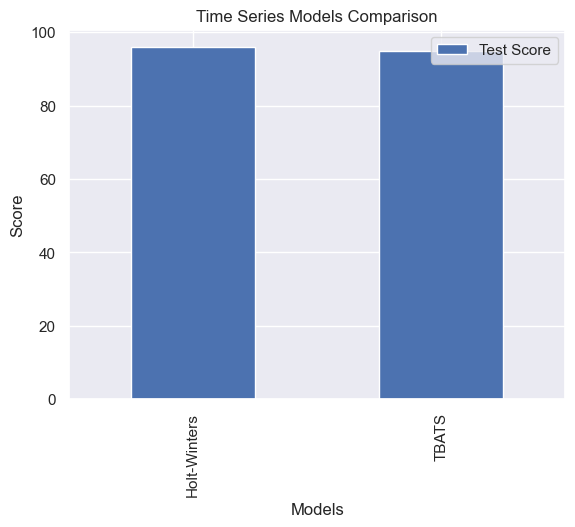

In [49]:
models_comparison.plot(kind='bar')
plt.xlabel('Models')
plt.ylabel('Score')
plt.title('Time Series Models Comparison');